In [1]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
import numpy as np
# import pylab
from datetime import datetime

# import os
# import math
# import random
import pandas as pd
# import itertools
from scipy.io import loadmat
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
from sklearn.metrics import balanced_accuracy_score

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [3]:

torch.cuda.is_available()

True

In [4]:
import torchvision.models as models
import torch.nn as nn
resnet = models.resnet18()

In [5]:

model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [6]:
# #Rasnet18
# resnet.conv1 = nn.Conv2d(in_channels=40, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
# resnet.fc = nn.Linear(2048, num_classes)

In [7]:
def train_model(model, dataloaders, criterion, optimizer, optimizer2, num_epochs=25, is_inception=False):
    
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    lr_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1e10
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            LabelList = torch.tensor([1]).to(device)
            PredList = torch.tensor([1]).to(device)
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_samples = 0
            confusion_matrix = torch.zeros(3, 3)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.type(torch.FloatTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                if epoch < 5:
                    optimizer.zero_grad()
                else:
                    optimizer2.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                     # statistics
                    epoch_samples += inputs.size(0)
                    LabelList = torch.cat([LabelList,labels.view(-1)],dim=0)
                    PredList = torch.cat([PredList, preds.view(-1)],dim=0)
#                     # statistics
#                     for t, p in zip(labels.view(-1), preds.view(-1)):
#                         confusion_matrix[t.long(), p.long()] += 1

                    running_corrects += torch.sum(preds == labels.data)


#                 confusionMat = np.asarray(confusion_matrix)
#                 sumconfusion = np.sum(confusionMat,axis = 1).T

#                 summat = np.tile(sumconfusion,(3,1)).T
                # print(test)
#                 percentconfusion = np.divide(confusionMat,summat)
                epoch_acc_balanced =  balanced_accuracy_score(LabelList[1:].cpu(), PredList[1:].cpu())

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
        

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
            
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()
        if epoch < 5:
            scheduler.step(epoch_loss)
        else:
            scheduler2.step(epoch_loss)
#         if epoch >= 6  and val_loss_history [-1] >= val_loss_history [-2] >= val_loss_history [-3] >= val_loss_history[-4]>=val_loss_history[-5]>=val_loss_history[-6]:
#             break
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history,train_loss_history, val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.conv1 = nn.Conv2d(in_channels=80, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 1
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(80, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [10]:
DatadirTrain = "H:\\WBCDataset_v4\\3DImagesKFold-aug"
DatadirVal = "H:\\WBCDataset_v4\\3DImagesKFold-aug"

In [11]:
# import os
# import os.path

# for dirpath, dirnames, filenames in os.walk("."):
#     for filename in [f for f in filenames if f.endswith(".log")]:
#         print os.path.join(dirpath, filename)
FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
tempName =FoldName
ValFold = tempName.pop(1)
# FoldName = tempName
print(FoldName)
print(ValFold)
for name in FoldName:
    print(name)

['Fold-1', 'Fold-3', 'Fold-4', 'Fold-5']
Fold-2
Fold-1
Fold-3
Fold-4
Fold-5


In [12]:
import os

def datapreparation(DatadirTrain,DatadirVal,Fold):
    trainpath = []
    FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
    ValFold = FoldName.pop(Fold)
    
    fpath = []
    traindir = DatadirTrain + "\\Gra_Y"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Lym_G"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Mon_U"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    minitrainpath = []
    minivalpath = []
    valpath = []
    
    fpath = []
    traindir = DatadirVal + "\\Gra_Y"+"\\"+ ValFold
    print(traindir)
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Gra mini-train data: %d' %(len(minitrain)))
    print('Gra mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Lym_G"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i]) 
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Lym mini-train data: %d' %(len(minitrain)))
    print('Lym mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Mon_U"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Mon mini-train data: %d' %(len(minitrain)))
    print('Mon mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])
    return trainpath,valpath,minitrainpath,minivalpath

In [13]:
Fold = 0
trainpath,testpath,_,_= datapreparation(DatadirTrain,DatadirVal,Fold)

Gra train data: 10856
Lym train data: 9791
Mon train data: 9113
H:\WBCDataset_v4\3DImagesKFold-aug\Gra_Y\Fold-1
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608


In [14]:
print('train data vol.: ',len(trainpath))
print('test data vol.: ',len(testpath))

train data vol.:  29760
test data vol.:  8202


In [15]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'Gra' in self.paths[index]:
            label = int(0)
        elif 'Lym' in self.paths[index]:
            label = int(1)
        elif 'Mon' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [16]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Granulocyte','Lymphocyte','Monocyte']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  29760
validation data volume:  8202
Cell Label:  Granulocyte
image tensor shape:  torch.Size([80, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80, 80)


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


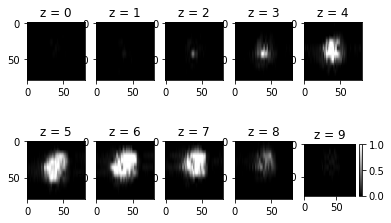

In [17]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Gra train data: 10856
Lym train data: 9791
Mon train data: 9113
H:\WBCDataset_v4\3DImagesKFold-aug\Gra_Y\Fold-1
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-06
train Loss: 0.7929 Acc: 0.6583
train Bal. Acc: 0.6515
val Loss: 0.7282 Acc: 0.6544
val Bal. Acc: 0.6739
saving best model
Total time: 0:10:25.929219
Epoch time: 10m 26s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.5365 Acc: 0.8030
train Bal. Acc: 0.7958
val Loss: 0.5105 Acc: 0.8066
val Bal. Acc: 0.8093
saving best model
Total time: 0:21:10.521475
Epoch time: 10m 45s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.4427 Acc: 0.8323
train Bal. Acc: 0.8273
val Loss: 0.4305 Acc: 0.8403
val Bal. Acc: 0.8411
saving best model
Total time: 0:31:08.965785
Epoch time: 9m 58s

Epoch 3/99
----------
LR 5e-06


val Loss: 0.4842 Acc: 0.8697
val Bal. Acc: 0.8720
Total time: 6:49:01.157175
Epoch time: 9m 49s

Epoch    35: reducing learning rate of group 0 to 3.1250e-06.
Epoch 41/99
----------
LR 3.125e-06
train Loss: 0.0112 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.4782 Acc: 0.8717
val Bal. Acc: 0.8731
Total time: 6:58:58.392159
Epoch time: 9m 57s

Epoch 42/99
----------
LR 3.125e-06
train Loss: 0.0102 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.4872 Acc: 0.8716
val Bal. Acc: 0.8736
Total time: 7:09:01.512570
Epoch time: 10m 3s

Epoch 43/99
----------
LR 3.125e-06
train Loss: 0.0101 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.4878 Acc: 0.8738
val Bal. Acc: 0.8747
Total time: 7:19:14.108149
Epoch time: 10m 13s

Epoch 44/99
----------
LR 3.125e-06
train Loss: 0.0103 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.4921 Acc: 0.8728
val Bal. Acc: 0.8744
Total time: 7:29:16.371836
Epoch time: 10m 2s

Epoch 45/99
----------
LR 3.125e-06
train Loss: 0.0087 Acc: 1.0000
train Bal. Acc: 1.0000
va

train Loss: 0.0014 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.5956 Acc: 0.8700
val Bal. Acc: 0.8714
Total time: 13:45:13.571533
Epoch time: 9m 42s

Epoch    77: reducing learning rate of group 0 to 4.8828e-08.
Epoch 83/99
----------
LR 4.8828125e-08
train Loss: 0.0013 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.5956 Acc: 0.8725
val Bal. Acc: 0.8716
Total time: 13:54:51.051895
Epoch time: 9m 37s

Epoch 84/99
----------
LR 4.8828125e-08
train Loss: 0.0026 Acc: 0.9998
train Bal. Acc: 0.9998
val Loss: 0.6078 Acc: 0.8665
val Bal. Acc: 0.8691
Total time: 14:04:38.421548
Epoch time: 9m 47s

Epoch 85/99
----------
LR 4.8828125e-08
train Loss: 0.0062 Acc: 0.9991
train Bal. Acc: 0.9991
val Loss: 0.6086 Acc: 0.8660
val Bal. Acc: 0.8678
Total time: 14:14:33.131954
Epoch time: 9m 55s

Epoch 86/99
----------
LR 4.8828125e-08
train Loss: 0.0018 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.6076 Acc: 0.8672
val Bal. Acc: 0.8694
Total time: 14:24:29.443771
Epoch time: 9m 56s

Epoch 87/99
------

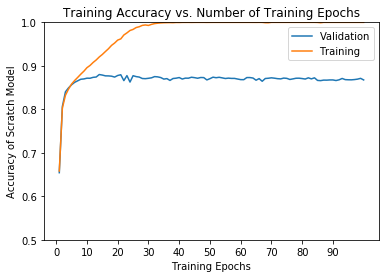

100


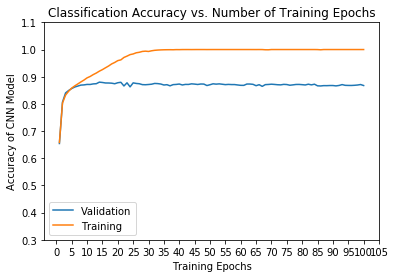

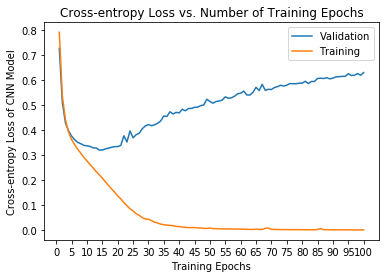

tensor([[2576.,   22.,  116.],
        [  89., 2018.,  344.],
        [ 124.,  289., 2624.]])
[2789. 2329. 3084.]
[[0.9491525  0.00810612 0.04274134]
 [0.03631171 0.82333744 0.14035088]
 [0.04082977 0.09515969 0.8640105 ]]





C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type "

In [19]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,1):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    Fold = runs
    trainpath,testpath,minitrainpath,minitestpath= datapreparation(DatadirTrain,DatadirVal,Fold)
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 80
    num_epochs = 100
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()
        # Initialize the non-pretrained version of the model used for this run
        scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
        scratch_model = scratch_model.to(device)
    #     scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.0005, momentum=0.9)
    #     scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=0.00001,betas = (0.9, 0.9999),eps=1e-08,weight_decay=0)
        scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=5e-6,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        scratch_optimizer2 = optim.Adam(scratch_model.parameters(),lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        scratch_criterion = nn.CrossEntropyLoss()
        model, scratch_hist_val,scratch_hist_train,loss_hist_train, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, scratch_optimizer2, num_epochs=num_epochs, is_inception=(model_name=="inception"))
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'WBCmodel-ResNet18-2D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'WBCmodel-ResNet18-2D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []

shist = scratch_hist_val
shist1 = scratch_hist_train
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
CellName = ['HEK293','HELA','MCF7']
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'ResNet18 - 3D Input')

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-resnet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:-1]))
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs).cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 40, n_iter=4000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']

In [ ]:

target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ResNet18 - 3D Input')
plt.show()